![Optional alt text](/images/advers_cat.png)

CIFAR-10 dataset contains in total of 60,000 colour images, divided into ten classes. This project aims to identify an image belonging to one of these ten categories. Further, the adversarial attacks are performed to check the robustness of such a trained model. The first part of the project is implemented via classes. The next part is designed with help of a decorator with arguments. 

# Data Preparation
In the first stage, I loaded the relevant libraries dataset CIFAR-10 and pre-processed. Next, I performed data augmentation. For the chosen residual architecture of the neural network, the optimal batch size is 400. If you have more memory on your graphic card, increasing the batch size in tandem with stronger data augmentation is recommended. The whole project works on GPU with device "cuda:0".

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
############################ To depict your neural network ################################################
#!pip install torchviz
from torchviz import make_dot
from graphviz import Digraph
########################### If you want to use TensorBoard ###############################################
#from torch.utils.tensorboard import SummaryWriter
########################## To plot #######################################################################
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
################### to dispaly confusing matrix properly install 'jupyterthemes' ########################
#!conda install -c conda-forge jupyterthemes # - for confusion matrix
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)
#########################################################################################################
print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("PyTorch version: ", torch.__version__ )

CUDA available:  True
PyTorch version:  1.11.0


Let's find the mean and standard deviation needed for normalisation during transformations of images. You have to create needed folders if it is necessary.

In [5]:
#! mkdir Data_Sets
transform_cifar10 = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor()
                               ])
tensor_cifar10 = datasets.CIFAR10(root='./Data_Sets/Cifar10', train=True, download=True, transform=transform_cifar10)

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
print(imgs.shape)
imgs.view(3, -1).mean(dim=1)

Files already downloaded and verified
torch.Size([3, 32, 32, 50000])


tensor([0.4914, 0.4822, 0.4465])

In [6]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

Obtained above values will be used for normalisation below. I also apply min_max() class to squeeze tensor values between 0 and 1. It is necessary, especially for projected attacks since it works with norms on $[0, 1]$ .

In [2]:
#! mkdir Data_Sets
torch.cuda.empty_cache()

class min_max():
    def __call__(self, tensor):
        tensor = tensor + torch.ones_like(tensor)
        tensor = tensor - tensor.min()
        tensor = tensor/(tensor.max()-tensor.min())
        return tensor
    
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomVerticalFlip(p=0.1),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      #transforms.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                                      #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                      transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                      min_max()                                      
                               ])

transform_test = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                     min_max()
                               ])
#I extract dataset from pytorch repository. Change folder if you wish. 
training_dataset = datasets.CIFAR10(root='./Data_Sets/Cifar10',
                              train=True, download=True,
                              transform=transform_train)
test_dataset = datasets.CIFAR10(root='./Data_Sets/Cifar10',
                                 train=False, download=True,
                                 transform=transform_test)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=400, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size =400, shuffle=True, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


Let's check some sample image

125
tensor(0.)
tensor(1.)


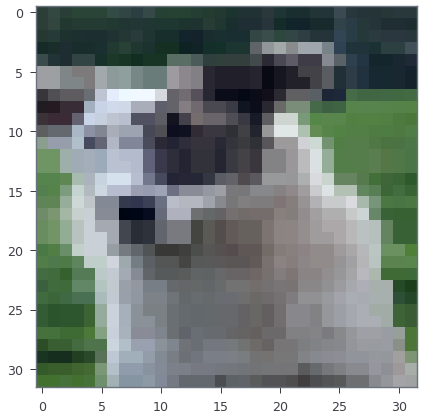

In [98]:
dataiter = iter(train_loader)
print(len(dataiter))
img, _ = dataiter.next()
img.shape
print(torch.min(img))
print(torch.max(img))
plt.imshow(img[1].permute(1, 2, 0))
plt.show()

In my mind, there is a dog above.

# Optimisation Parameters of Residual Neural Network
CIFAR-10 comprises a training set of 50,000 images with ten classes to classify. The test set contains 10,000 images. To achieve over 90 per cent test accuracy, I used a residual convolutional neural network (NN) architecture [1] with residual blocks. The idea is that after a series of convolution-ReLU-convolution operations, the signal is passed to the output. Some blocks can be bypassed. Thus the final signal is still strong enough even if a network is very deep. In this way, we mitigate the problem of vanishing gradients and can build more deep networks in which we do not rely only on general mappings from input to output but also on so-called residual mappings. In other words, we apply "skip connections". Images in CIFAR10 were scaled to 32x32 sizes, so it is convenient to use automatic convolution with a kernel size of 3 and padding of 1 to avoid losing any pixels. To capture the growing complexity of features, I use an increased number of filters from 64 to 1024. The detailed design of NN is depicted
[here](/images/Residual_net.png). For better resolution, create your own diagram using 'torchviz'.<br>Such construction of NN will result in over 93% accuracy, which is pretty enough to demonstrate the idea of adversarial attacks.

In [5]:
###################################### functions ##################################################
def init_weights(m):
    if isinstance(m, nn.Conv2d):    
        nn.init.kaiming_normal_(m.weight.data,mode='fan_in',nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 0.5)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def accuracy(outputs, labels):
    '''Computes accuracy'''
    pred = 0.0
    _, val_preds = torch.max(outputs, 1)
    pred += torch.sum(val_preds == labels.data)
    return pred

class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
       https://github.com/Bjarten/early-stopping-pytorch"""
    
    def __init__(self, patience=7, verbose=False, delta=0, path='Models/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'{bcolors.FAIL}EarlyStopping counter: {self.counter} out of {self.patience}{bcolors.RESET}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'{bcolors.OK}Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...{bcolors.RESET}')            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Neural Network's Residual Blocks and Neural Network Model

In [6]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=1, bias=False),
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]#you can add expansion here
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
        
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        in_channels = in_channels
        num_classes = num_classes

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True) 
        self.conv4 = conv_block(256, 256, pool=False)
        self.conv5 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv6 = conv_block(512, 1024, pool=False)
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(1024, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.res2(out) + out
        out = self.conv6(out)
        out = self.classifier(out)
        return out

#### Class for training, validation and plotting

In [9]:
class Fab():
    def __init__(self, model):
        self.trained_model = model
    
    def fit(self, epochs, learn_rate, train_loader, test_loader, patience, pct_start):
        '''Trainer'''
        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=patience, verbose=True)
        grad_clip = 0.08 # Use gradient clipping
        criterion = nn.CrossEntropyLoss()# loss function
        optimizer = torch.optim.Adam(self.trained_model.parameters(), lr = learn_rate, weight_decay=1e-4)#, eps=1e-8)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learn_rate, epochs=epochs,\
             steps_per_epoch=len(train_loader), pct_start=pct_start, div_factor=30)#, three_phase=True)

        self.run_train_loss = []
        self.run_train_acc = []
        self.run_test_loss = []
        self.run_test_acc = []
        self.batches_train = []
        self.batches_test = []
        self.lrs = []
        torch.cuda.empty_cache()
        for k in range(epochs):
            train_loss = 0.0
            train_acc = 0.0
            test_loss = 0.0
            test_acc= 0.0
            
            self.trained_model.train() #train mode   
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()# reset values of derivativesfrom graphs
                outputs = self.trained_model(inputs)# model processes
                loss = criterion(outputs, labels)# loss is computed
                self.batches_train.append(loss.item())# needed for plots
                loss.backward() # BACKPROPAGATION
                nn.utils.clip_grad_value_(self.trained_model.parameters(), grad_clip)
                optimizer.step() # parameter update based on current gradient stored in .grad attribute of a parameter
                scheduler.step()
                rate = optimizer.param_groups[0]['lr']
                self.lrs.append(rate)
                
                train_loss += loss.item() # accumaulate loss (should go down )
                train_acc += accuracy(outputs, labels) # accuracy
            else:
                self.trained_model.eval()# eval mode to turn off dropouts or batchnormalisation
                with torch.no_grad():# wrapper temporarily puts all 'requires_grad flag' to flase. 
                    for tes_inputs, tes_labels in test_loader:
                        tes_inputs = tes_inputs.to(device)
                        tes_labels = tes_labels.to(device)
                        tes_outputs = self.trained_model(tes_inputs)
                        tes_loss = criterion(tes_outputs, tes_labels)
                        self.batches_test.append(tes_loss.item())
                        test_loss += tes_loss.item()
                        test_acc += accuracy(tes_outputs, tes_labels.data)
    
                epoch_loss = train_loss/len(train_loader)
                epoch_acc = train_acc.float()/ len(train_loader.dataset) #divide by the longth of entire dataset
                self.run_train_loss.append(epoch_loss)
                self.run_train_acc.append(epoch_acc.detach().cpu().numpy())
                tes_epoch_loss = test_loss/len(test_loader)
                tes_epoch_acc = test_acc.float()/ len(test_loader.dataset)
                self.run_test_loss.append(tes_epoch_loss)
                self.run_test_acc.append(tes_epoch_acc.detach().cpu().numpy())
                
                if (k + 1) % 1 == 0:    
                        print('Epoch [{}/{}] with rate: {:.6f}, Loss: {:.4f} / {:.4f}, Accuracy: {:.4f}  / {:.4f} '\
                              .format(k + 1, epochs, rate, self.run_train_loss[k], self.run_test_loss[k],\
                                   self.run_train_acc[k], self.run_test_acc[k]))
                                                 
                early_stopping(tes_epoch_loss, self.trained_model)
                if early_stopping.early_stop:
                    print(f"{bcolors.FAIL}Early stopping{bcolors.RESET}")
                    print(' ')
                    break
        # load the last checkpoint with the best model; you will have to create folder 'Models'
        self.trained_model.load_state_dict(torch.load('Models/checkpoint.pt'))
                                                 
    def plotti(self):
        fig, ax = plt.subplots(2, 2, figsize=(18, 11))
        ax[0,0].plot(range(1, len(self.run_train_loss)+1), self.run_train_loss,\
            c='indigo',linewidth=1.8, label='Train loss')
        ax[0,0].plot(range(1, len(self.run_test_loss)+1), self.run_test_loss,\
            c='deeppink',linewidth=1.8, label='Test loss')
        opt_poss = self.run_test_loss.index(min(self.run_test_loss))+1 
        ax[0,0].axvline(opt_poss, linestyle='--', color='b',label='Obtained Model')
        ax[1,0].plot(self.batches_train, c='grey', alpha=0.5, label='Train minibatch cost')
        ax[1,0].plot(np.convolve(self.batches_train, np.ones(10,)/10, mode='valid'),\
            c='indigo',linewidth=1 , label='Running average')
        ax[1,1].plot(self.batches_test, c='grey', alpha=0.5, label='Test minibatch cost')
        ax[1,1].plot(np.convolve(self.batches_test, np.ones(10,)/10, mode='valid'),\
             c='deeppink',linewidth=1 , label='Running average')
        ax[0,1].plot(range(1, len(self.run_test_acc)+1), self.run_test_acc,\
             c='deeppink',linewidth=1.8, label='Test accuracy')
        ax[0,1].plot(range(1, len(self.run_train_acc)+1), self.run_train_acc,\
             c='indigo',linewidth=1.8, label='Train accuracy')
        ax[0,1].axvline(opt_poss, linestyle='--', color='b',label='Obtained Model')
        ax[0,0].set(xlabel="Epochs",ylabel="Loss")
        ax[0,1].set(xlabel="Epochs",ylabel="Accuracy")
        ax[0,1].set(ylabel="Accuracy") 
        ax[1,0].set_ylim([0, 1.7])
        ax[1,0].set(xlabel="Number of iterations", ylabel="Train CrossEntropy")
        ax[1,1].set(xlabel="Number of iterations", ylabel="Test CrossEntropy")
        ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()
        plt.tight_layout()
        plt.show()

Regarding hyperparameters, I use 400 batch-size. It seems to be a good trade-off between speed of optimisation and desired accuracy. However, it slightly overfits our model at the last stage of the training (train longer for better and model the training cycle via a scheduler). Thus I applied EarlyStoping class to prevent too excessive overfitting. Anyway, slight overfitting is advisable in our case because it increases the robustness of the trained model. Besides, data augmentation and batch normalisations help much here. As an optimiser, I employed Adam since it uses past gradients to compute present gradients and momentum. The latter is using the moving averages instead of the gradient itself. The learning rate was set up according to the one-cycle scheduler, with the peak at 0.0004. It is low but typical for Adam. I optimise with cross-entropy as a loss function to measure the difference between distributions of classified objects. Cross-entropy plays well with activation functions as the derivative depends only on neurons' outputs, targets, and inputs. In other words, cross-entropy deals well with the potential problem of saturated neurons. Gradient clipping prevents losing the right path and seems indispensable for cosine schedulers.
<br>The reader can visualise the structure of the neural network by using the script below. You have to install torchviz through 'pip install torchviz' to use the snippet below. 

In [10]:
model2 = ResNet(3, 10)
x = torch.randn(1, 3, 32, 32).requires_grad_(True)
y = model2(x)
make_dot(y, params=dict(list(model2.named_parameters()))).render("Residual_net", format="png")

'Residual_net.png'

#### Now we can train our model 
If necessary create folder 'Models' for storing, i.e., Fab() will store trained model in the 'Models' for further usage.

In [57]:
!mkdir Models
trainer = Fab(ResNet(3, 10).apply(init_weights).to(device))
trainer.fit(36, 0.0045, train_loader, test_loader, 7, 0.27)

Epoch [1/36] with rate: 0.000263, Loss: 1.5204 / 1.3121, Accuracy: 0.4570  / 0.5378 
Validation loss decreased (inf --> 1.312075).  Saving model ...
Epoch [2/36] with rate: 0.000590, Loss: 1.1853 / 1.0342, Accuracy: 0.5792  / 0.6365 
Validation loss decreased (1.312075 --> 1.034181).  Saving model ...
Epoch [3/36] with rate: 0.001096, Loss: 1.0251 / 1.2177, Accuracy: 0.6375  / 0.6021 
EarlyStopping counter: 1 out of 7
Epoch [4/36] with rate: 0.001730, Loss: 0.9039 / 0.9791, Accuracy: 0.6833  / 0.6678 
Validation loss decreased (1.034181 --> 0.979051).  Saving model ...
Epoch [5/36] with rate: 0.002426, Loss: 0.8238 / 0.7967, Accuracy: 0.7102  / 0.7346 
Validation loss decreased (0.979051 --> 0.796745).  Saving model ...
Epoch [6/36] with rate: 0.003112, Loss: 0.7677 / 0.6977, Accuracy: 0.7300  / 0.7594 
Validation loss decreased (0.796745 --> 0.697677).  Saving model ...
Epoch [7/36] with rate: 0.003715, Loss: 0.7158 / 0.6057, Accuracy: 0.7498  / 0.7878 
Validation loss decreased (0.69

On the plots, you can observe the training process. There are mini-batch costs and their moving averages at the bottom. The trained model is slightly overfitted, which is in favour of adversarial robustness later [7]. To achieve around 90% training accuracy, you can shorten the training process to 12 epochs only.

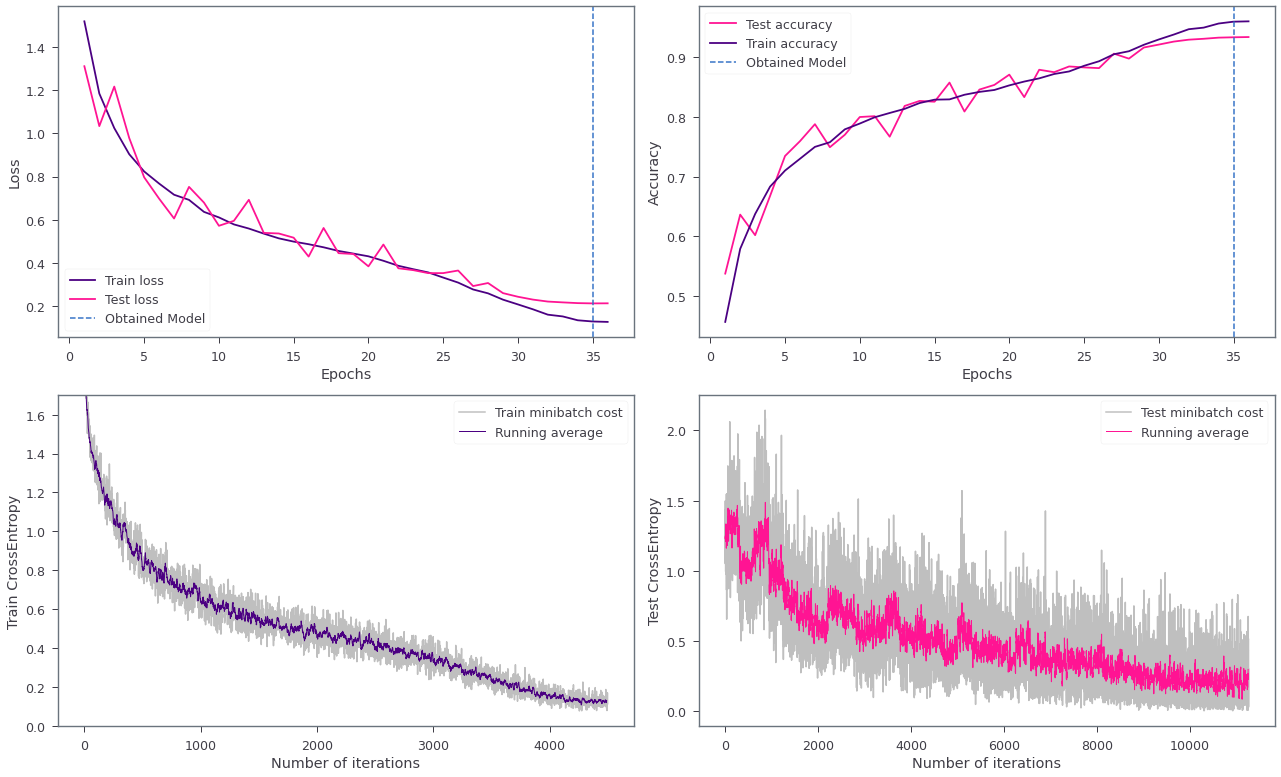

In [58]:
trainer.plotti()

To display the scheduler profile

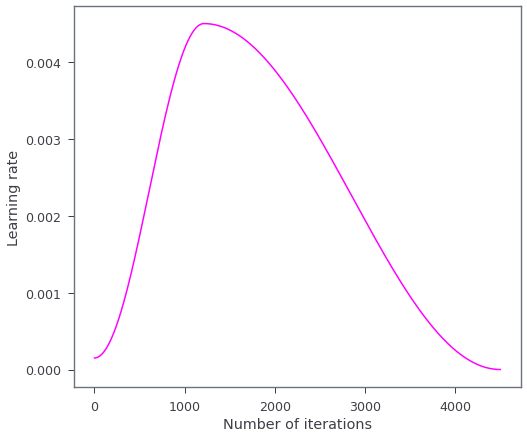

In [59]:
plt.plot(trainer.lrs, c='magenta')
plt.xlabel('Number of iterations')
plt.ylabel('Learning rate')
plt.show()

#### Load trained model from the checkpoint.pt

In [60]:
my_model = trainer.trained_model
#Model is loaded from the checkpoint
my_model.load_state_dict(torch.load('Models/checkpoint.pt'))

<All keys matched successfully>

If you want to load the previousely trained model, activate all cells up to the Fab() class and do not touch these two lines:

'''

trainer = Fab(ResNet(3, 10).apply(init_weights).to(device))

trainer.fit(36, 0.0045, train_loader, test_loader, 7, 0.27)

'''

Next as follows

In [11]:
# trainer = Fab(ResNet(3, 10).apply(init_weights).to(device))
# my_model = trainer.trained_model
# #Model is loaded from the checkpoint
# my_model.load_state_dict(torch.load('Models/checkpoint.pt'))

<All keys matched successfully>

#### Now we can display random predictions

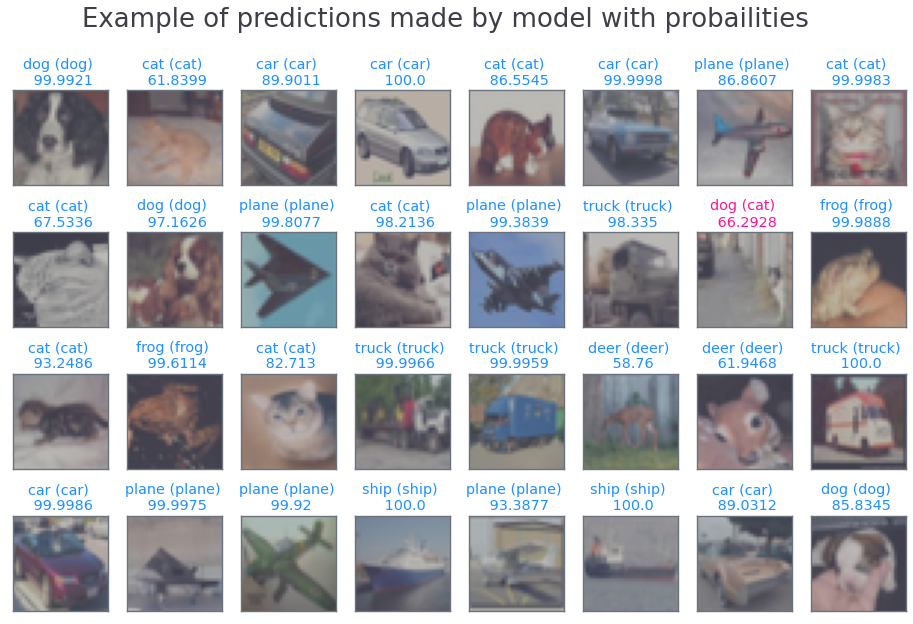

In [14]:
################ Load and denormalise images ###############################################
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def im_convert(tensor):
    '''Denormalisation'''
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.4914, 0.4822, 0.4465)) + np.array((0.2470, 0.2435, 0.2616))
    image = image.clip(0, 1)
    return image

############## Computes soft-max probability for randomnly chosen image #####################
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = my_model(images)
_, preds = torch.max(output, 1)
output_probs = F.softmax(output, dim=1)
output_probs = output_probs.cpu()
x_pred_prob =  np.round((torch.max(output_probs.data, 1)[0]) * 100,4)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Example of predictions made by model with probailities', fontsize=26)
for idx in np.arange(32):
    sm = nn.Softmax(dim=1)
    sm_outputs = sm(output)
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({}) \n {}".format(str(classes[preds[idx].item()]),\
                                     str(classes[labels[idx].item()]),\
                                     str(x_pred_prob.numpy()[idx])), \
                                     color=("dodgerblue" if preds[idx]==labels[idx] else "deeppink"))

These pictures are a part of the classification results in the testing set. The numbers over the images are the probabilities (confidences) about classification correctness, which comes from the softmax function according to the categories that the pictures are classified. You can observe that our model works pretty well. Later we will check its robustness. 

#### The confusion matrix is very convenient for depicting the overall accuracy of every category

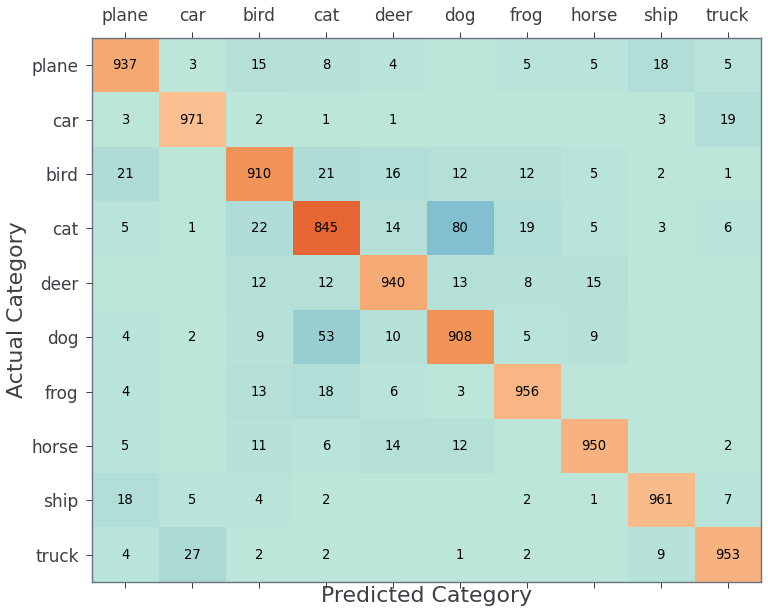

 
Category   - Accuracy
plane      - 93.7
car        - 97.1
bird       - 91.0
cat        - 84.5
deer       - 94.0
dog        - 90.8
frog       - 95.6
horse      - 95.0
ship       - 96.1
truck      - 95.3


In [36]:
#################### Computes accuracies for each of ten categories  ######################

def conf_mat(val_loader, model, matrix=False):
    total_correct = 0
    total_images = 0
    conf_mat = np.zeros([10,10], int)
    with torch.no_grad():
        for img, labels in val_loader:
            img = img.to(device)
            labels = labels.to(device)
            outputs = model(img)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, k in enumerate(labels):
                conf_mat[k.item(), predicted[i].item()] += 1 
                
    model_accuracy = total_correct / total_images * 100
    
    if matrix: 
        ###################### Confusion matrix #############################################
        jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
        fig, ax = plt.subplots(1,1,figsize=(12,10))
        ax.matshow(conf_mat, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('icefire'))
        for i, j in zip(*conf_mat.nonzero()):
            ax.text(j, i, conf_mat[i, j], color='black', ha='center', va='center')
        ax.set_ylabel('Actual Category', fontsize=22)
        plt.yticks(range(10), classes, fontsize=17)
        ax.set_xlabel('Predicted Category', fontsize=22)
        plt.xticks(range(10), classes, fontsize=17)
        plt.show()
    ##################### Produce the table ################################################# 
    print(' ')
    print('{0:10s} - {1}'.format('Category','Accuracy'))
    for i, r in enumerate(conf_mat):
        print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))
    
conf_mat(test_loader, my_model, matrix=True)

The worst accuracy is for the cats. From the confusing matrix, it is evident that the model classifies too many dogs as cats and vice versa, i.e. false positives, namely II type error. Statistically, the model accepts hypothesis, $H_{0}$ when it is false. Note that FGSM adversarially lowers the number of true positives favouring false negatives.

# Adversarial Attacks
To check the robustness of our trained model, I applied three types of adversarial attacks. The idea is that if our model correctly classified some input data, we impose perturbation $\delta$ to that input data $x$ to escape from the minimum of the objective function. We set weights (trained model parameters) and compute gradients w.r.t input data in an adversarial algorithm. As a result, the algorithm goes in the direction of the gradient and hence there is a gradient ascent. Note that in gradient descent, we impose a negative sign to go in the opposite direction of the gradient. In general, the aim of the adversarial attack is to create imperceptible data inputs such that the model misclassifies these inputs.
For perturbated input ${x'}=x+\delta\,\,\in[0,1]^{n}$ and output $y$ we obtain not true labels and we can write
$$f_{\Theta}({x'})\neq y_{true}$$
Also, a perturbation should be fixed on each pixel by size $\epsilon$ (max perturbation), and we obtain bounded adversarial pixel within 
$\epsilon$-neigbourhood for $L_{p}$ norm
$$||{x'}-x||_{p}<\epsilon$$
, which in general can be written as $$\displaystyle \max_{x}Loss(f(x+\delta),y), \,\,\,\delta\in\mathcal{B}_{\epsilon}(x)$$ 
or if we use a negative loss
$$\displaystyle \min_{x}-Loss(f(x+\delta),y),\,\,\,\delta\in\mathcal{B}_{\epsilon}(x)$$ 
where ${B}_{\epsilon}(x)$ is a ball. Thus, we compute the gradient w.r.t input, $x$, and our aim is to find a $x$ s.t. the loss is maximized that leads to the misclassification. 

In the case of metric spaces, the distance can be measured by means of standard $L_{p}$ norms.

There are ten classes in Cifar-10, so we deal with the maulti-class attack where every point gets assigned to input class, $C_{i}$ for $i=1,...,k=10$. Therefore, there are $k=10$ discriminant classes, $g_{i}(x)$. In case of correct classification, point $x$ is classified as $C_{i}$ if discriminat $g_{i}(x)\geq g_{j}(x),\,\,\forall i\neq j$ for any other region $j$ of nine remaining regions (in case of the CIFAR-10). Namely, our discriminant $g_{i}(x)$ is higher than the value of any other discrimant applied on $x$ but mapped from other region $j$, thus
$$g_{1} - g_{i}\leq 0$$
$$\vdots$$
$$g_{k} - g_{i}\leq 0$$

Equivalently, we want the worst discriminator to be non-positive
$$\displaystyle \max_{x_{j\neq i}}g_{j}(x)-g_{i}(x)\leq 0$$
However, as a result of attack, our point, $x$, is shifted to class $C_{t}$ (targeted), that is why we would like the constrained inequality
$$\displaystyle \max_{x_{j\neq t}}g_{j}(x)-g_{t}(x)\leq 0$$
where $g_{t}(x)$ is the discriminant function of the target space, and $g_{j}(x)$ are the discriminants functions of the all other classes st $i\neq j$. In the last eqn., we have to be sure that if we pass $x$ into  $g_{t}(x)$ then it would give us the max value in comparision to the $x$ value under discriminat in any other space, $g_{j}(x)$. <br>
 ![image info](/images/adv2.jpg)


If we think of an untargeted attack, we consider 
$$g_{i}(x)-\displaystyle \max_{x_{j\neq i}}g_{j}(x)\leq 0$$ 
where the current(input) class $g_{i}(x)$ must be less than any other class, even the weakest one, among the classes we are considering. It means that for a successful attack $x$ can be shifted to any class $j$ and the algorithm considers all classes $j$. If you need a more deep explanation google Stanley Chan. It is also worth mentioning that the set in question is not necessarily convex.

In this notebook, I decided to demonstrate the idea using proposed by Goodfellow et. al [3]: Fast Gradient Sign Method (FGSM) and Iterative Fast Gradient Sign Method (I-FSGM) together with Projected Gradient Descent Method (PGD-attack). The distance function is $L_{\infty}$, i.e., we measure max distance between any pixel $x'$ and $x$ with the possible perturbation directions at $+/- 45^{\circ}$ or $+/- 135^{\circ}$, which are corners of the square of $L_{\infty}$ norm. Therefore, FGSM under $L_{\infty}$ cannot be the optimal attack since it excludes the more optimal directions of perturbation, which are possible for $L_{2}$ norm.
Basic FGSM is an untargeted method that perturbs input by $\epsilon$ in one step only. "sign" because the algorithm goes along the gradient, whose sign is detected during PyTorch operations on graphs during backpropagation. The algorithm is based on the following optimization problem with $\delta$ as perturbation

$$\displaystyle \max_{\delta}\nabla_{x}Loss(x; w)^{T}\delta+Loss(x; w)\,\,\, subject\,\, to\,\,\, ||\delta||_{\infty}\leq \epsilon$$

The above results in the solution where $x'$ is an adversarial example 

$$x'=x+\epsilon\cdot sgn\,(\nabla_{x}J(x, y_{true}))$$

FGSM is the basic example of Maximum Loss Attack where the constraint is $||x'-x||_{p}\leq \epsilon$ and the objective is to maximize $g_{t}(x)-\displaystyle \max_{x_{j\neq i}}g_{j}(x)$, where we substruct from target everything what is NOT a target. 

The development of FSGM is I-FGSM which imposes multiple perturbations along the gradient on a graph. Naturally, this method is superior to the first because the move is deeper (it accumulates values of gradients from $n$ iterations of a loop). We also limit the magnitude of each perturbation so that the distortion is still in $\epsilon$-neigbourhood. We took $\alpha=\frac{\epsilon}{n}$ and write

$$x_{0}' = x;\,\,\,\, x_{n+1}'=Clip_{x,\epsilon} \left \{  x_{n}' +\,\,\alpha\cdot sgn\,(\nabla_{x_{n}'}J(x_{n}', y_{true}))   \right \} $$

These algorithms shift examples adversarially beyond the set in which the model correctly classified them. In other words, true positives become false negatives. Goodfellow claims that adversarialness stems from linear behaviours of subspaces in highly nonlinear spaces of neural networks [2], whereas the true target is still the same. However, the newer approach claims that when the dimensionality of the set of functions increases, we have to deal with different spaces; that is, the norms of all vectors change and hence target moves [4]. 

Madry et al. proposed the projection of perturbation onto a ball ${B}_{\epsilon}(x)$ around an example $x$. Before gradient calculation, the uniform noise is added.
$$x_0'= x +\mathrm{U}(-\epsilon, \epsilon)$$
$$x_{n+1}'=\Pi_{{B}_{\epsilon}(x)}({x_{n}'}+\alpha \cdot sgn(\nabla_{x_{n}'}Loss(f(x_{n}',y))) $$
where $\Pi_{{B}_{\epsilon}(x)}$ is the projection onto ${B}_{\epsilon}(x)$.<br>
As you see the last two algorithms are very similar.

# Implementation of FSGM,  I-FSGM and PGD attacks
For attacks, I applied the decorator with arguments. Decorated functions also admit arguments if it is necessary.

In [53]:
############################# PLOTTER of IMAGES ##################################################
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def im_convert_2(tensor):
    '''Denormalisation'''
    image = tensor.transpose(1, 2, 0)
    #image = image * np.array((0.4914, 0.4822, 0.4465)) + np.array((0.2470, 0.2435, 0.2616))
    image = image.clip(0, 1)
    return image

def plotter(imgs, probas, classes, epsilons):
    '''To plot samples of perturbed images'''
    cnt = 0
    plt.figure(figsize=(13,17))
    #plt.suptitle('Examples of predictions of model with probailities after FGSM attack', fontsize=28)
    for i in range(len(epsilons)):
        for j in range(len(imgs[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(imgs[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=16)
            orig,adv,ex = imgs[i][j]
            plt.title("{} ({}) \n {}".format(str(classes[adv]),\
                                        str(classes[orig]),\
                                        str(probas[i][j]) ), \
                                        color=("dodgerblue" if classes[orig]==classes[adv] else "deeppink"), fontsize=18)
            plt.imshow(im_convert_2(ex[:,:]))
    plt.tight_layout()
    plt.show()
    
#################################### ATTACK DECORATOR ####################################################
def main_attack(model, device, test_loader, epsilons, matrix=False):
    def decorator(func):
        def wrapper(*args, **kwargs):
            '''Skeleton for FGSM computations'''
            classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
            accuracies = []
            examples = []
            probs = []
            for eps in epsilons:
                conf_mat = np.zeros([10,10], int)
                correct = 0
                adv_examples = []
                x_probs = []
             
                for img, target in test_loader:
                    img, target = img.clone().detach().to(device), target.clone().detach().to(device)
                    
                    model.to(device)
                    model.eval()
                    with torch.no_grad():
                        output = model(img)
                        # get the index of the max log-probability
                        init_pred = output.max(1, keepdim=True)[1] 
                    if eps == 0.0:
                        perturbed_img = img
                    else:
                        perturbed_img = func(model, img, target, eps, *args, **kwargs)
                    #to get perturbed img
                    output = model(perturbed_img)
                    #softmax for probabilities
                    output_probs = F.softmax(output, dim=1)#standardise for probability
                    output_probs = output_probs.clone().detach().cpu()
                    #get probability for given image from tensor
                    x_pred_prob =  (np.round((torch.max(output_probs.data, 1)[0]) * 100,4)).numpy()
                    # Check for success
                    # get the index of the max log-probability
                    final_pred = output.max(1, keepdim=True)[1]
                    for i, k in enumerate(target):
                        conf_mat[k.item(), final_pred[i].item()] += 1
                    if final_pred.item() == target.item():
                        correct += 1
                    # Save some adv examples for visualization later; here 7 columns
                    if len(adv_examples) <7:
                        adv_ex = perturbed_img.squeeze().detach().cpu().numpy()
                        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                        x_probs.append(x_pred_prob)
                acc = correct/float(len(test_loader))
                print("Epsilon: {}\tTest Accuracy = {} / {} = {:.4f}".format(eps,\
                     correct, len(test_loader), acc))

                accuracies.append(acc)
                examples.append(adv_examples)
                probs.append(x_probs)
                print(' ')

                if matrix: 
                    ###################### Confusion matrix #############################################
                    jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
                    fig, ax = plt.subplots(1,1,figsize=(8,6))
                    ax.matshow(conf_mat, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('icefire'))
                    for i, j in zip(*conf_mat.nonzero()):
                        ax.text(j, i, conf_mat[i, j], color='black', ha='center', va='center')
                    ax.set_ylabel('Actual Category', fontsize=12)
                    plt.yticks(range(10), classes, fontsize=13)
                    ax.set_xlabel('Predicted Category', fontsize=12)
                    plt.xticks(range(10), classes, fontsize=13)
                    plt.show()
            return accuracies, examples, probs
        return wrapper
    return decorator

#### Load test images

In [56]:
test2_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

## FGSM
$$x'=x+\epsilon\cdot sgn\,(\nabla_{x}J(x, y_{true}))$$
The distance measure is $L_{\infty}$ . 'torch.autograd.grad' is used to compute derivative of loss w.r.t inputs. Next the perturbation is added. Technically, there is a gradient ascent in the attack's case.

Epsilon: 0.0	Test Accuracy = 9331 / 10000 = 0.9331
 


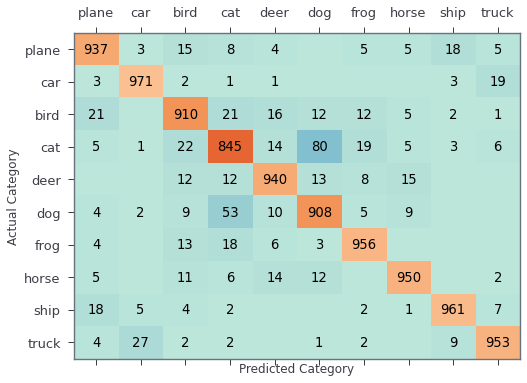

Epsilon: 0.0025	Test Accuracy = 8181 / 10000 = 0.8181
 


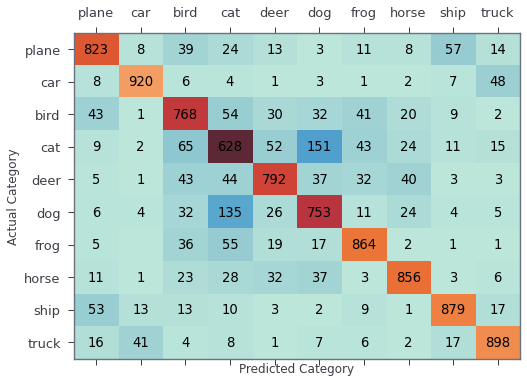

Epsilon: 0.005	Test Accuracy = 6740 / 10000 = 0.6740
 


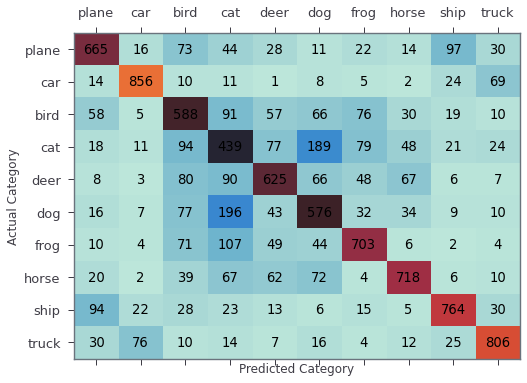

Epsilon: 0.0075	Test Accuracy = 5296 / 10000 = 0.5296
 


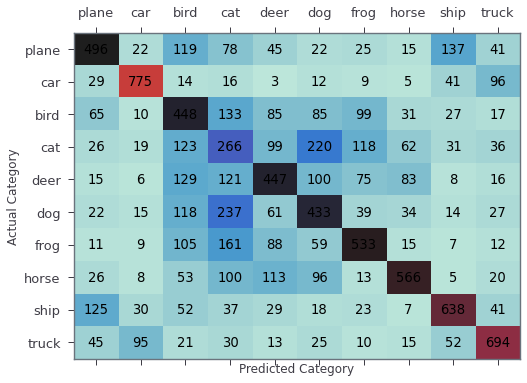

Epsilon: 0.01	Test Accuracy = 4161 / 10000 = 0.4161
 


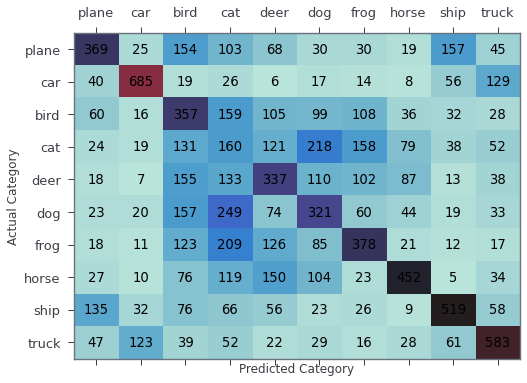

Epsilon: 0.02	Test Accuracy = 1738 / 10000 = 0.1738
 


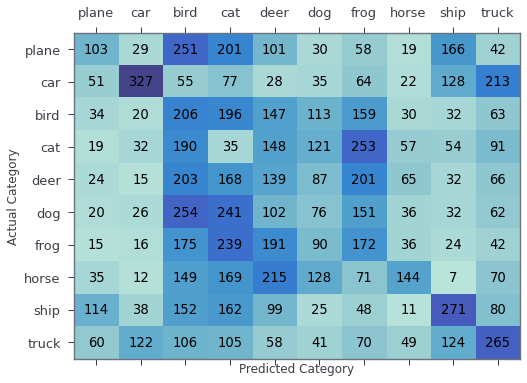

Epsilon: 0.03	Test Accuracy = 941 / 10000 = 0.0941
 


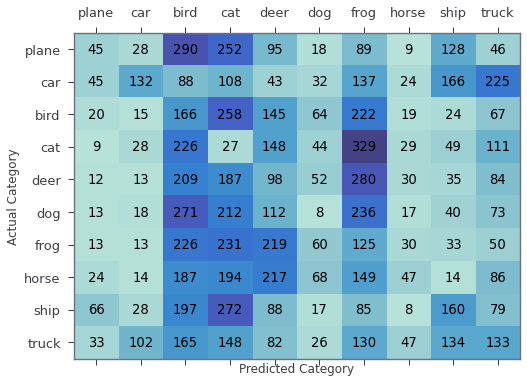

Epsilon: 0.04	Test Accuracy = 690 / 10000 = 0.0690
 


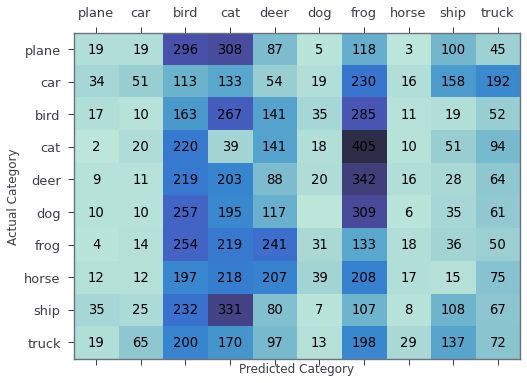

In [57]:
epsilons = [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.04]
@main_attack(my_model, device, test2_loader, epsilons, matrix=True)
def fgsm(model, img, target, eps):
    '''FGSM algorithm'''
    img_adv = img.clone().detach().to(device)
    img_adv.requires_grad = True
    output = model(img_adv)
    loss = F.nll_loss(output, target)#computes loss
    #We do not want to perform further operations on gradients
    #We do not need the graph of derivatives to be constructed
    #By analogy we have in_place chain of derivatives like in python generator
    grad = torch.autograd.grad(loss, img_adv, retain_graph=False, create_graph=False)[0]
    perturb = img_adv + eps*grad.sign() #as in formula
    perturbed_img = perturb.detach()
    return perturbed_img

accuracies_fgsm, imgs_fgsm, probas_fgsm = fgsm()

## Iterative FGSM
$x_{0}' = x;\,\,\,\, x_{n+1}'=Clip_{x,\epsilon} \left \{  x_{n}' +\,\,\alpha\cdot sgn\,(\nabla_{x_{n}'}J(x_{n}', y_{true}))   \right \} $, where
$Clip_{x, \epsilon}$ means $min(max(x', x-\epsilon), x+\epsilon)$


The distance measure is $L_{\infty}$ and $\alpha = \frac{\epsilon}{n}$, where $n$ is iteration.

Plotting confusing matrices during the attacks for each $\epsilon$ demonstrates how the true positives are turned into the false negatives. Moreover, we can visualise which classes are most susceptible to a given attack. Later, this observation can be applied, e.g., for targeted attacks or adversarial training. 

Epsilon: 0.0	Test Accuracy = 9331 / 10000 = 0.9331
 


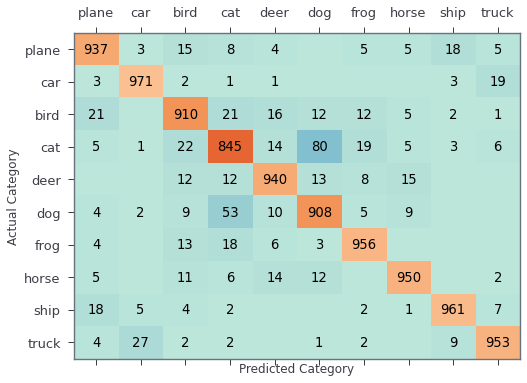

Epsilon: 0.0025	Test Accuracy = 8085 / 10000 = 0.8085
 


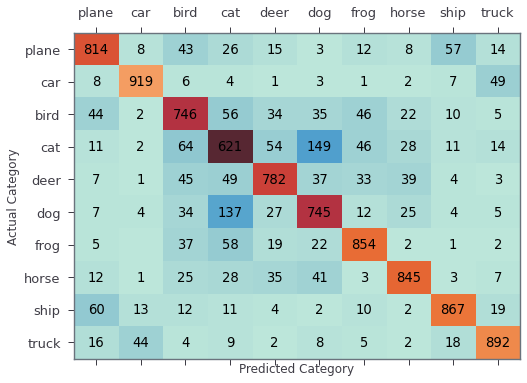

Epsilon: 0.005	Test Accuracy = 6245 / 10000 = 0.6245
 


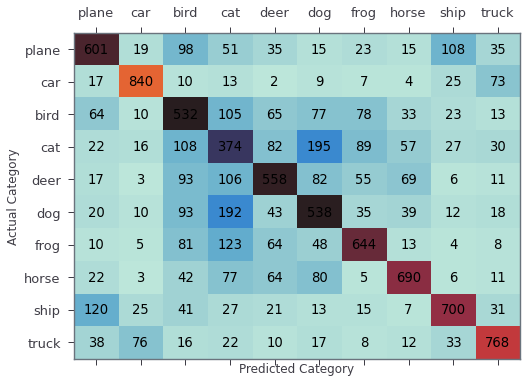

Epsilon: 0.0075	Test Accuracy = 4247 / 10000 = 0.4247
 


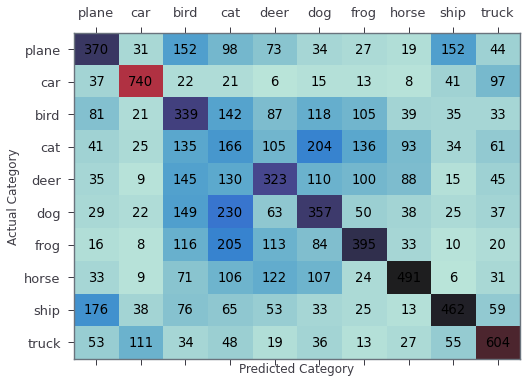

Epsilon: 0.01	Test Accuracy = 2646 / 10000 = 0.2646
 


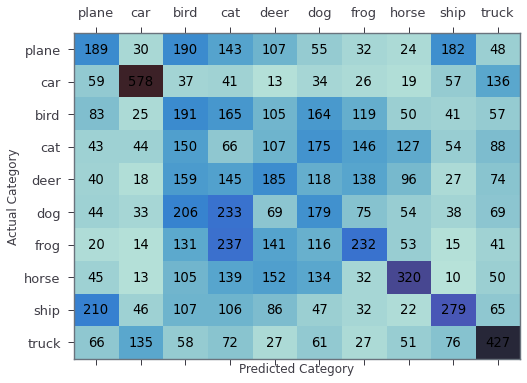

Epsilon: 0.02	Test Accuracy = 179 / 10000 = 0.0179
 


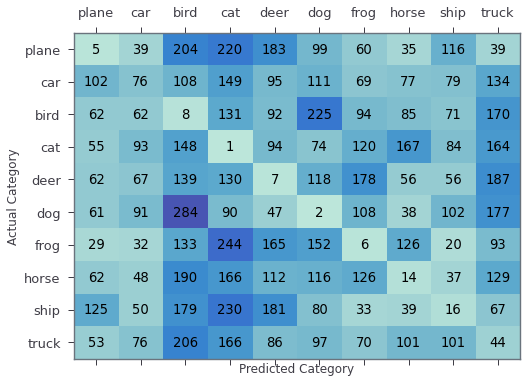

Epsilon: 0.03	Test Accuracy = 7 / 10000 = 0.0007
 


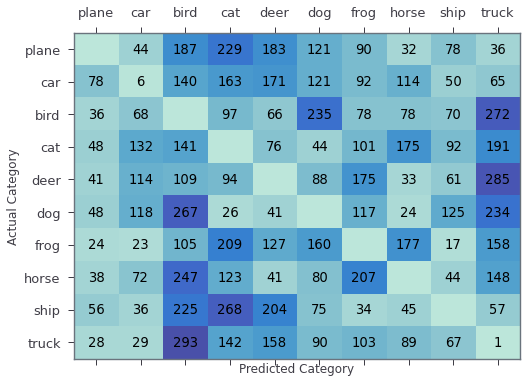

Epsilon: 0.04	Test Accuracy = 0 / 10000 = 0.0000
 


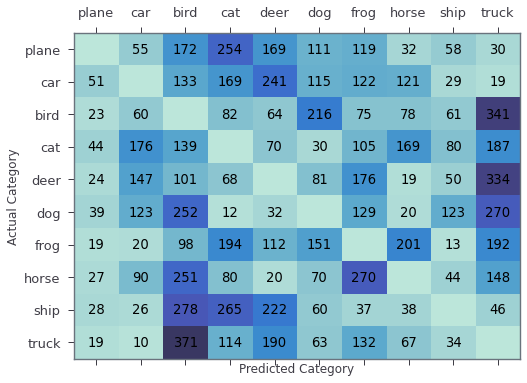

In [58]:
epsilons = [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.04]
@main_attack(my_model, device, test2_loader, epsilons, matrix=True)
def I_fgsm(model, img, target, eps, iters):
    '''I-FGSM algorithm'''
    img_adv = img.clone().detach().to(device)
    for i in range(1,iters):
        img_adv.requires_grad=True
        output = model(img_adv)
        loss = F.nll_loss(output, target)#computes loss
        grad = torch.autograd.grad(loss, img_adv, retain_graph=False, create_graph=False)[0]
        alpha = eps/i
        # add perturbation to img which also contains perturbation from previous iterations
        perturbed = img_adv.data + alpha * grad.sign()
        x_adv = torch.min(torch.max(perturbed, img-eps), img+eps)
        img_adv.data = x_adv
        perturbed_img = x_adv.detach()
    return perturbed_img

iters = 5
accuracies_I5_fgsm, imgs_I5_fgsm, probas_I5_fgsm = I_fgsm(iters)

We observe that the attack has shifted all the true positives to incorrect sets, which resulted in total misclassification. Namely if $x\in C_{i}$ then after attack the perturbed $x'\notin C_{i}$ but any other class, $C_{j}$, instead where $j\neq i$.

## PGD 
Madry et al. proposed  the projection of perturbation to a ball ${B}_{\epsilon}(x)$ around an example $x$. Before gradient calcualtion, the uniform noise is added.
$$x_0'= x +\mathrm{U}(-\epsilon, \epsilon)$$
$$x_{n+1}'=\Pi_{{B}_{\epsilon}(x)}({x_{n}'}+\alpha \cdot sgn(\nabla_{x_{n}'}Loss(f(x_{n}',y))) $$
where $\Pi_{{B}_{\epsilon}(x)}$ is the projection onto ${B}_{\epsilon}(x)$, here $[0,1]$ in $L_{\infty}$.
The distance measure is $L_{\infty}$. However, in later post I will show you how to apply projection in $L_{2}$ spaces onto tensor. 
The link to the paper by Hoki Kim is [here](https://arxiv.org/pdf/2010.01950.pdf).


Epsilon: 0.0	Test Accuracy = 9331 / 10000 = 0.9331
 


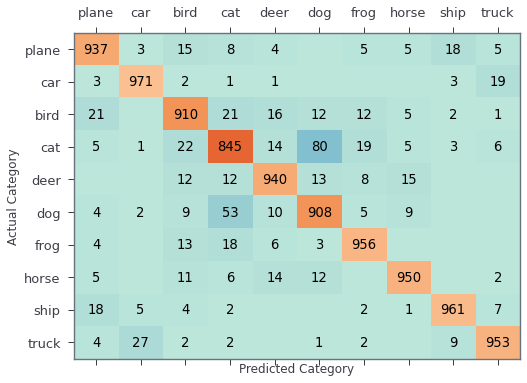

Epsilon: 0.0025	Test Accuracy = 8063 / 10000 = 0.8063
 


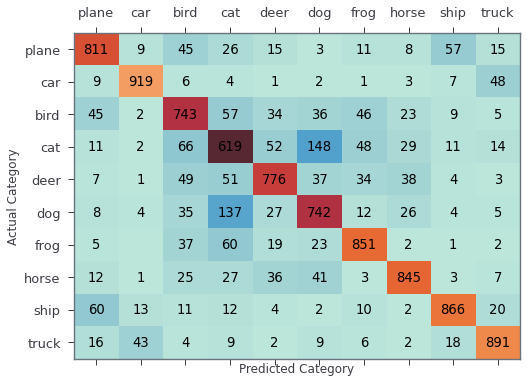

Epsilon: 0.005	Test Accuracy = 6151 / 10000 = 0.6151
 


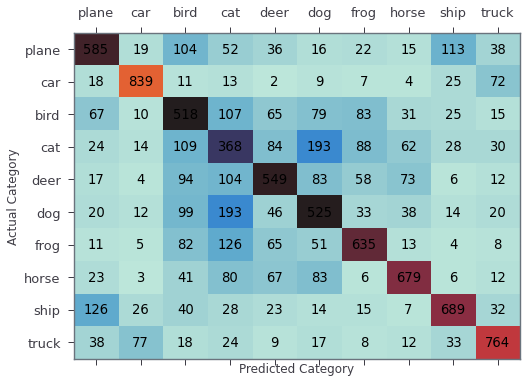

Epsilon: 0.0075	Test Accuracy = 4034 / 10000 = 0.4034
 


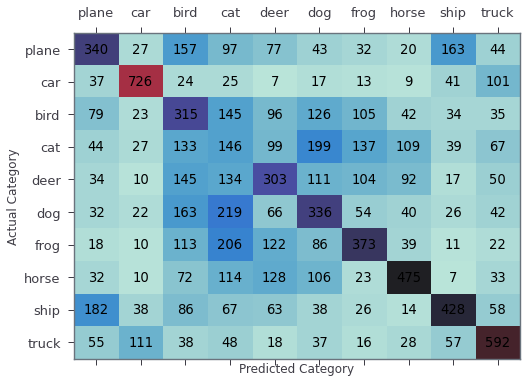

Epsilon: 0.01	Test Accuracy = 2421 / 10000 = 0.2421
 


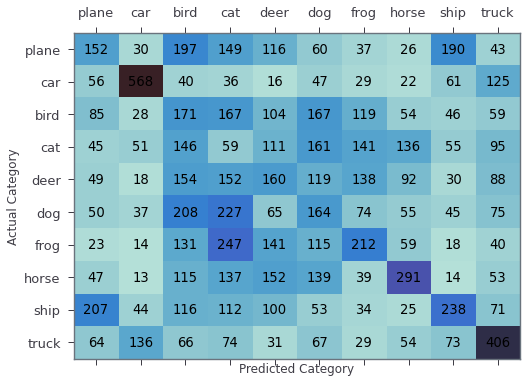

Epsilon: 0.02	Test Accuracy = 121 / 10000 = 0.0121
 


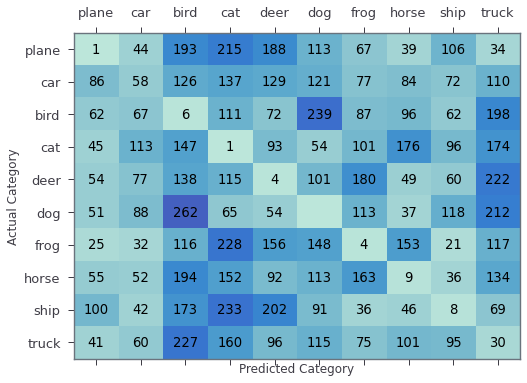

Epsilon: 0.03	Test Accuracy = 2 / 10000 = 0.0002
 


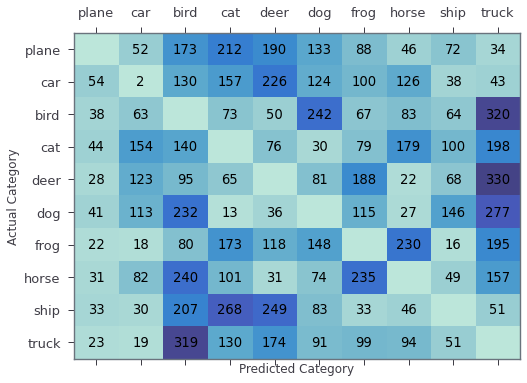

Epsilon: 0.04	Test Accuracy = 0 / 10000 = 0.0000
 


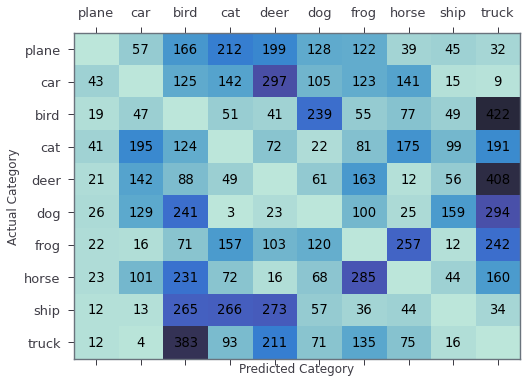

In [59]:
epsilons = [0.0, 0.0025, 0.005, 0.0075, 0.01, 0.02, 0.03, 0.04]
@main_attack(my_model, device, test2_loader, epsilons, matrix=True)
def PGD(model, img, target, eps, iters, random_init=False):
    '''PGD algorithm'''
    img_adv = img.clone().detach().to(device)
    
    if random_init:
        img_adv = img_adv + torch.empty_like(img_adv).uniform_(-eps, eps)
        img_adv = torch.clamp(img_adv, min=0, max=1).detach()
    for i in range(1, iters+1):
        img_adv.requires_grad=True
        output = model(img_adv)
        loss = F.nll_loss(output, target)#computes loss
        grad = torch.autograd.grad(loss, img_adv, retain_graph=False, create_graph=False)[0]
        alpha = eps/i
        #to detetect a sign of gradient * alpha = perturbation; alpha should be less than epsilon
        # add perturbation to img which also contains perturbation from previous iterations
        perturb_a = img_adv.detach() + alpha * grad.sign()
        #clips intermediate values after each step to ensure being in epsilon-neigbourhood
        perturb_b = torch.clamp(perturb_a - img, -eps, eps)
         #add total perturbation to the original image and stay in the infinity space ball in [0, 1]
        x_adv = torch.clamp(img + perturb_b, 0, 1)
        img_adv.data = x_adv
        perturbed_img = x_adv.detach()
    return perturbed_img

iters = 5
accuracies_I5_proj, imgs_I5_proj, probas_I5_proj = PGD(iters, random_init=True)

There is not a very big difference between I-FGSM and PDG attacks but matrices show that PDG is always superior. Both I-FGSM and PDG are projections, but in PDG there is the additional projection onto subspace $[0, 1]$ within $L_{\infty}$ metric space, and optionally one can use uniform initialisation. Mind that some can see the difference between them if there is uniform initialisation in the case of PDG. Moreover, this [paper](https://arxiv.org/pdf/2010.01950.pdf) states that the robustness of the model under I-FGSM training can be more effective on CIFAR-10 than that under PDG. A lot depends on the architecture of the neural network, the dataset used for training and the norm space. Nevertheless, PGD can show off much better effectiveness in $L_{2}$ spaces, which I will demonstrate in a separate post. To acquaint yourself with the ropes of projection, I recommend a linear algebra course and next   ["Introductory Functional Analysis with Applications" by Kreyszig](https://www.amazon.co.uk/Introductory-Functional-Analysis-Applications-Classics/dp/0471504599/ref=sr_1_fkmr0_1?crid=1XH5QPUOJ1BJ2&keywords=introduction+to+functional+analysis+kreyszig&qid=1653478806&sprefix=introduction+to+functional+analysis+kreyszig%2Caps%2C48&sr=8-1-fkmr0). There is also the excellent ["An Introduction to Optimization"](https://www.amazon.co.uk/Introduction-Optimization-Wiley-Discrete-Mathematics-ebook/dp/B00BCQCFQS/?_encoding=UTF8&pd_rd_w=efpQd&pf_rd_p=4d619998-507a-44d3-b580-1c7fc24282f7&pf_rd_r=SJE7V2FBQJ515CRQNCZT&pd_rd_r=82432430-06fc-4d84-b3a4-abdf03fad74f&pd_rd_wg=qJYdb&ref_=pd_gw_ci_mcx_mr_hp_atf_m) by Chong and Zak to learn about optimisation.

#### Let's plot how the model accuracy changes in relation to the $\epsilon$

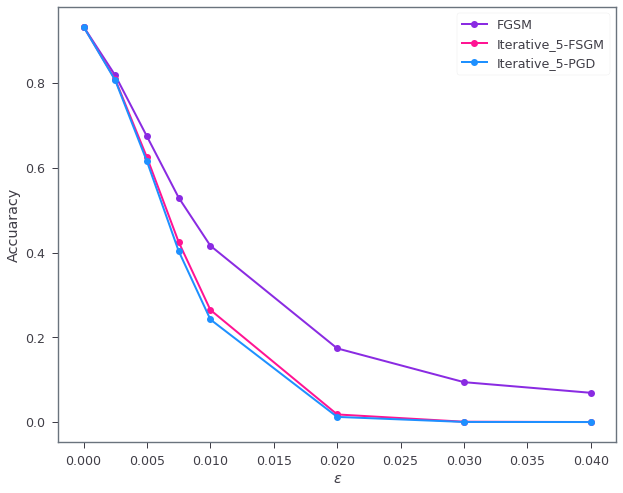

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(epsilons, accuracies_fgsm, c='blueviolet', marker='o',\
   label='FGSM', linewidth=2.0)
ax.plot(epsilons, accuracies_I5_fgsm, c='deeppink', marker='o',\
   label='Iterative_5-FSGM', linewidth=2.0)
ax.plot(epsilons, accuracies_I5_proj, c='dodgerblue', marker='o',\
   label='Iterative_5-PGD', linewidth=2.0)
ax.set(xlabel="$\epsilon$", ylabel="Accuaracy")
ax.legend()
plt.show()

As mentioned above, there is no big difference between I-FGSM and PDG since both are similar projections, especially in the context of $L_{\infty}$ norm. The gap would be wider if I applied more iterations but it is very time-consuming. The differences are more apparent if we compare matrices. 

We can visualize perturbated examples for particular $\epsilon$. We observe a growing level of misclassifications either if radiuses of ball or number of iterations grow during attacks.
## FGSM

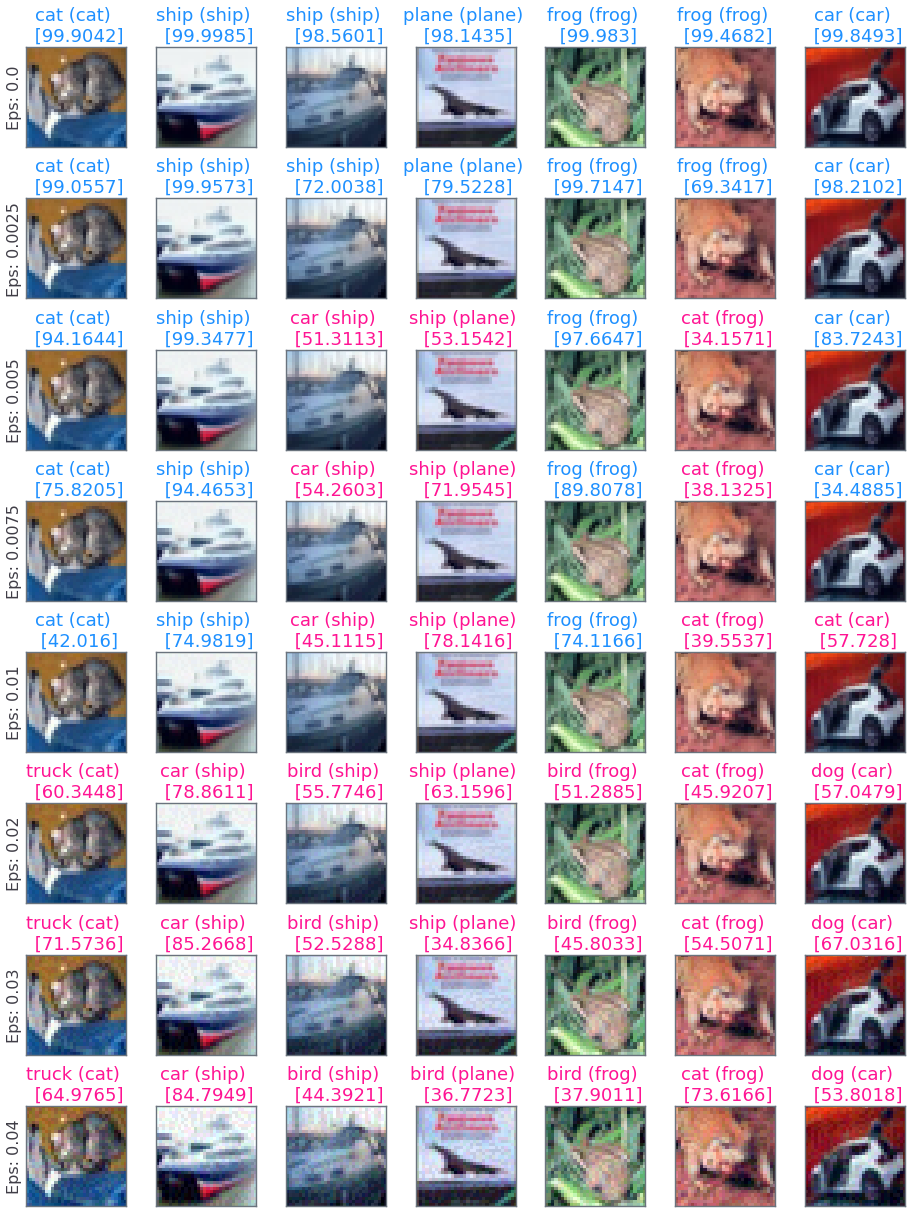

In [61]:
plotter(imgs_fgsm, probas_fgsm, classes, epsilons)

## I-FGSM

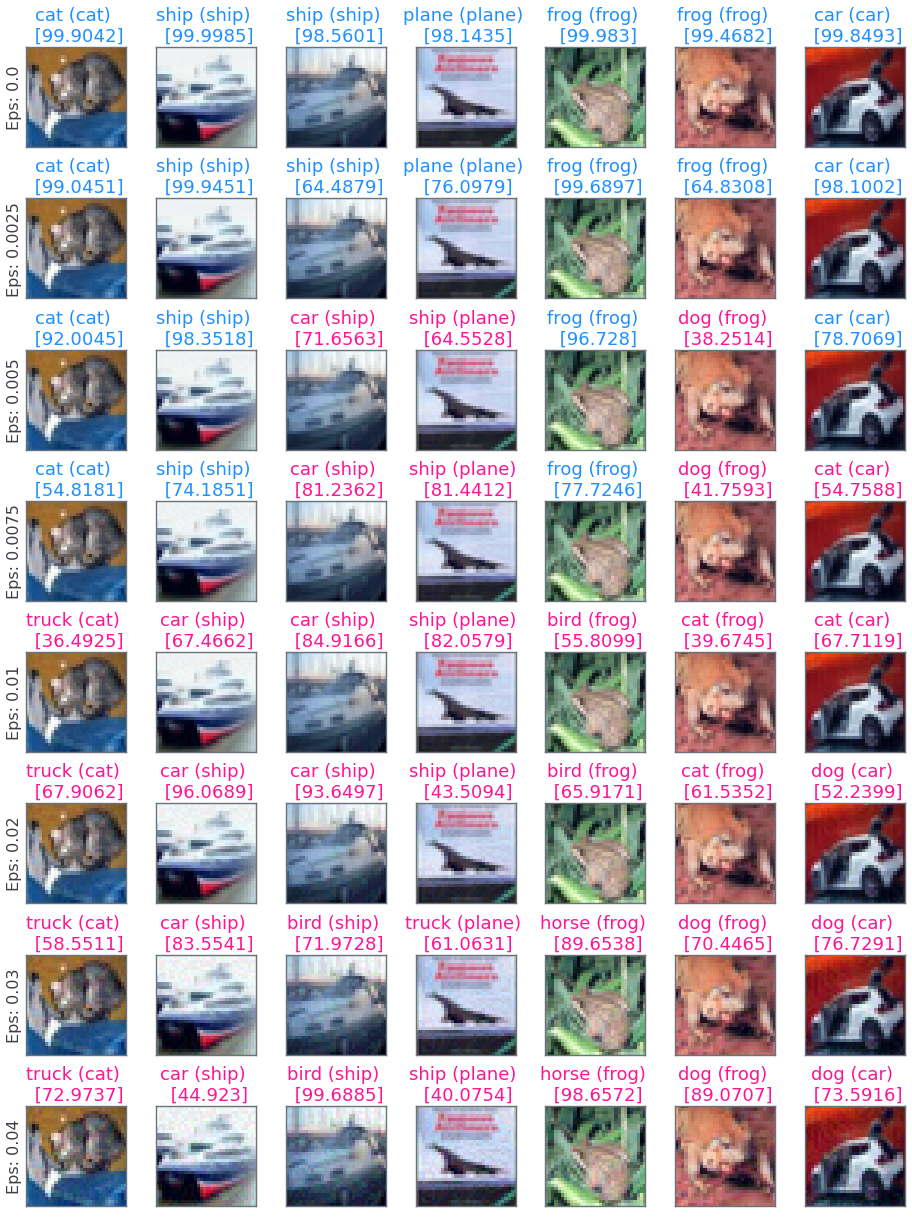

In [62]:
plotter(imgs_I5_fgsm, probas_I5_fgsm, classes, epsilons)

## PGD attack

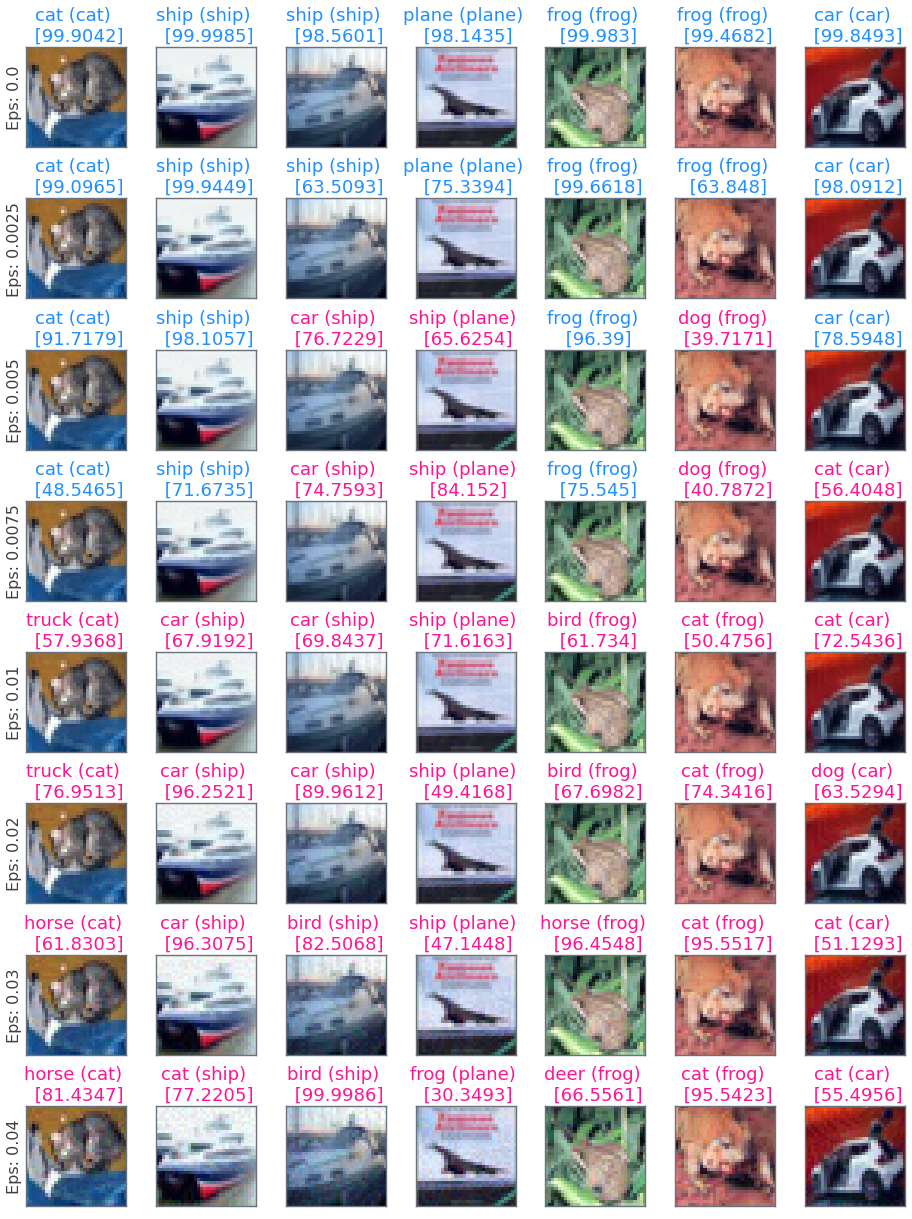

In [63]:
plotter(imgs_I5_proj, probas_I5_proj, classes, epsilons)

In the pictures above, we can see the work of applied attacks and their growing power. That is, small additive perturbation disturbs the process of classification, and our model mispredicts classes.


Thank you for reading. I do hope that the notebook is interesting and you could learn something from it either as far as the theory or about coding. If you have any questions or remarks, drop me a message or comment.

[1]  He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

[2] Goodfellow, I.J., Shlens, J. and Szegedy, C., 2014. Explaining and harnessing adversarial examples. arXiv preprint arXiv:1412.6572.

[3] Kurakin, A., Goodfellow, I. and Bengio, S., 2016. Adversarial examples in the physical world. arXiv preprint arXiv:1607.02533.

[4] Dube, S., 2018. High dimensional spaces, deep learning and adversarial examples. arXiv preprint arXiv:1801.00634.

[5] Zagoruyko, S. and Komodakis, N., 2016. Wide residual networks. arXiv preprint arXiv:1605.07146.

[6] Tsipras, D., Santurkar, S., Engstrom, L., Turner, A. and Madry, A., 2018. Robustness may be at odds with accuracy. arXiv preprint arXiv:1805.12152.

[7] Deniz, O., Pedraza, A., Vallez, N. et al. Robustness to adversarial examples can be improved with overfitting. Int. J. Mach. Learn. & Cyber. 11, 935–944 (2020).